# Predicting Song Genres Using Spotify Data

## Description

This project aims to build a machine learning model that predicts the genre of a song using various metrics provided by Spotify. The goal is to create a predictive model that can  classify the genre of a song based on its features such as danceability, energy, tempo, and other characteristics. Additionally, this project will use the Spotify API to retrieve these song metrics for any new track, allowing us to make predictions on new songs.

### Workflow

1. Collect Data
    
    Build a dataset within Spotify

2. Preprocess Data:

    Clean and preprocess dataset for model training.
3. Train Models:
    


    Train models using the audio metrics as features and genre as target.
    
    Evaluate the model's performance using cross-validation and metrics (accuracy, F1-score).
4. Evaluate Model Performance:

    Check for the effectiveness of the model. Analyze predictions.
5. Integrate Spotify API:
    
6. Make Predictions on New Songs:
    
    Use the trained machine learning model to predict the genre of any new song based on its Spotify audio features.

## Import Libraries

In [1791]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Spotify API Setup

In [1794]:
!pip install dotenv

python(9396) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


  Using cached dotenv-0.0.5.tar.gz (2.4 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [67 lines of output]
      /opt/anaconda3/lib/python3.12/site-packages/setuptools/__init__.py:81: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_build_eggs(dist.setup_requires)
        error: subprocess-exited-with-error
      
        × python setup.py egg_info did not run successfully.
        │ exit code: 1
        ╰─> [1 lines of output]
            ERROR: Can not exe

In [2851]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.exceptions import SpotifyException
from dotenv import load_dotenv
import os


#load_dotenv()
load_dotenv()
client_id = os.environ.get('client_id')
client_secret = os.environ.get('client_secret')

# Authenticate with Spotify API
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=client_id, client_secret=client_secret))

# Test
result = sp.search(q='breath away', type='track', limit=1)
print(result)

ImportError: cannot import name 'load_dotenv' from 'dotenv' (/opt/anaconda3/lib/python3.12/site-packages/dotenv/__init__.py)

In [2781]:
# Test
result = sp.search(q='breath away', type='track', limit=1)
print(result)

{'tracks': {'href': 'https://api.spotify.com/v1/search?query=breath+away&type=track&offset=0&limit=1', 'items': [{'album': {'album_type': 'album', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0PCCGZ0wGLizHt2KZ7hhA2'}, 'href': 'https://api.spotify.com/v1/artists/0PCCGZ0wGLizHt2KZ7hhA2', 'id': '0PCCGZ0wGLizHt2KZ7hhA2', 'name': 'Artemas', 'type': 'artist', 'uri': 'spotify:artist:0PCCGZ0wGLizHt2KZ7hhA2'}], 'available_markets': ['AR', 'AU', 'AT', 'BE', 'BO', 'BR', 'BG', 'CA', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DK', 'DO', 'DE', 'EC', 'EE', 'SV', 'FI', 'FR', 'GR', 'GT', 'HN', 'HK', 'HU', 'IS', 'IE', 'IT', 'LV', 'LT', 'LU', 'MY', 'MT', 'MX', 'NL', 'NZ', 'NI', 'NO', 'PA', 'PY', 'PE', 'PH', 'PL', 'PT', 'SG', 'SK', 'ES', 'SE', 'CH', 'TW', 'TR', 'UY', 'US', 'GB', 'AD', 'LI', 'MC', 'ID', 'JP', 'TH', 'VN', 'RO', 'IL', 'ZA', 'SA', 'AE', 'BH', 'QA', 'OM', 'KW', 'EG', 'MA', 'DZ', 'TN', 'LB', 'JO', 'PS', 'IN', 'KZ', 'MD', 'UA', 'AL', 'BA', 'HR', 'ME', 'MK', 'RS', 'SI', 'KR', 'B

### Retreive Audio Features

In [2065]:
def get_audio_features(track_id):
    # get audio features for a specific track
    features = sp.audio_features([track_id])
    return features[0] 

track_id = result['tracks']['items'][0]['id']
audio_features = get_audio_features(track_id)
print(audio_features)  # Replace with actual API call

{'danceability': 0.694, 'energy': 0.712, 'key': 11, 'loudness': -6.522, 'mode': 0, 'speechiness': 0.0759, 'acousticness': 0.707, 'instrumentalness': 0.0202, 'liveness': 0.263, 'valence': 0.233, 'tempo': 146.015, 'type': 'audio_features', 'id': '1oic0Wedm3XeHxwaxmwO91', 'uri': 'spotify:track:1oic0Wedm3XeHxwaxmwO91', 'track_href': 'https://api.spotify.com/v1/tracks/1oic0Wedm3XeHxwaxmwO91', 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1oic0Wedm3XeHxwaxmwO91', 'duration_ms': 166849, 'time_signature': 4}


## Building a Dataset

In [2620]:
import random

count = 6
def search_songs_by_genre(genre, limit=10):
    global count
    songs_data = []
    results = sp.search(q=f'genre:{genre}', type='track', limit=limit, offset=count * random.randint(1, 100))
    
    for track in results['tracks']['items']:
        track_id = track['id']
        audio_features = get_audio_features(track_id)
        if audio_features:
            audio_features['genre'] = genre
            songs_data.append(audio_features)
    
    return songs_data

# List of 20 genres
genres = [
    'pop', 'rock', 'jazz', 'classical', 'hip-hop', 'metal', 'reggae', 'blues',
    'country', 'edm', 'latin', 'soul', 'punk', 'folk', 'funk', 'indie', 'disco',
    'r&b', 'gospel', 'alternative'
]

all_songs_data = []

for genre in genres:
    print(f"Collecting songs for genre: {genre}")
    genre_songs = search_songs_by_genre(genre, limit=25)  
    all_songs_data.extend(genre_songs)
    time.sleep(15)

df = pd.DataFrame(all_songs_data)

print(df.shape)
df.info()

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=2ixsaeFioXJmMgkkbd4uj1:
 Max Retries, reason: too many 429 error responses

In [ ]:
df['genre'].value_counts()

In [ ]:
genres = [
    'pop', 'rock', 'jazz', 'classical', 'hip-hop', 'metal', 'reggae', 'blues',
    'country', 'edm', 'latin', 'soul', 'punk', 'folk', 'funk', 'indie', 'disco',
    'r&b', 'gospel', 'alternative'
]

In [ ]:
# I append new API call data to dataset file trying to take into account possible data mismatch issues.
try:
    df.query("genre in @genres").drop(columns='Unnamed: 0').reset_index(drop=True).to_csv('clean_spotify_set_2.csv', mode='a', 
                                                                                          header=False, index=True)
except:
    df.query("genre in @genres").reset_index(drop=True).to_csv('clean_spotify_set_2.csv', mode='a', header=False, index=True)

In [2655]:
# I read the Spotify song dataset I've collected.
df = pd.read_csv('clean_spotify_set_2.csv', index_col=0, header='infer').reset_index(drop=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1480 non-null   float64
 1   energy            1480 non-null   float64
 2   key               1480 non-null   float64
 3   loudness          1480 non-null   float64
 4   mode              1480 non-null   float64
 5   speechiness       1480 non-null   float64
 6   acousticness      1480 non-null   float64
 7   instrumentalness  1480 non-null   float64
 8   liveness          1480 non-null   float64
 9   valence           1480 non-null   float64
 10  tempo             1480 non-null   float64
 11  type              1480 non-null   object 
 12  id                1480 non-null   object 
 13  uri               1480 non-null   object 
 14  track_href        1480 non-null   object 
 15  analysis_url      1480 non-null   object 
 16  duration_ms       1480 non-null   int64  


In [2657]:
# The below aggregate score was added in the course of testing, but only produced marginal and mixed effects on models.
# df['weighted_score'] = df['duration_ms']* 3 + 0.2 * df['danceability']  + 0.2 * df['energy']+ 0.2 * df['valence']

In [2659]:
# I check if repeated API calls added duplicate tracks in a temporary dataframe and remove them.
print(df.duplicated().sum())
df1 = df.drop_duplicates().reset_index(drop=True)
df1.info()

0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1480 entries, 0 to 1479
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      1480 non-null   float64
 1   energy            1480 non-null   float64
 2   key               1480 non-null   float64
 3   loudness          1480 non-null   float64
 4   mode              1480 non-null   float64
 5   speechiness       1480 non-null   float64
 6   acousticness      1480 non-null   float64
 7   instrumentalness  1480 non-null   float64
 8   liveness          1480 non-null   float64
 9   valence           1480 non-null   float64
 10  tempo             1480 non-null   float64
 11  type              1480 non-null   object 
 12  id                1480 non-null   object 
 13  uri               1480 non-null   object 
 14  track_href        1480 non-null   object 
 15  analysis_url      1480 non-null   object 
 16  duration_ms       1480 non-null   int64 

In [2661]:
df = df1.copy()

In [2663]:
df.head(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
0,0.700,0.582,11.0,-5.960,0.0,0.0356,0.05020,0.000000,0.0881,0.785,116.712,audio_features,0WbMK4wrZ1wFSty9F7FCgu,spotify:track:0WbMK4wrZ1wFSty9F7FCgu,https://api.spotify.com/v1/tracks/0WbMK4wrZ1wF...,https://api.spotify.com/v1/audio-analysis/0WbM...,218424,4,pop
1,0.747,0.507,2.0,-10.171,1.0,0.0358,0.20000,0.060800,0.1170,0.438,104.978,audio_features,6dOtVTDdiauQNBQEDOtlAB,spotify:track:6dOtVTDdiauQNBQEDOtlAB,https://api.spotify.com/v1/tracks/6dOtVTDdiauQ...,https://api.spotify.com/v1/audio-analysis/6dOt...,210373,4,pop
2,0.521,0.592,6.0,-7.777,0.0,0.0304,0.30800,0.000000,0.1220,0.535,157.969,audio_features,2plbrEY59IikOBgBGLjaoe,spotify:track:2plbrEY59IikOBgBGLjaoe,https://api.spotify.com/v1/tracks/2plbrEY59Iik...,https://api.spotify.com/v1/audio-analysis/2plb...,251668,3,pop
3,0.674,0.907,3.0,-4.086,1.0,0.0640,0.10100,0.000000,0.2970,0.721,112.964,audio_features,5G2f63n7IPVPPjfNIGih7Q,spotify:track:5G2f63n7IPVPPjfNIGih7Q,https://api.spotify.com/v1/tracks/5G2f63n7IPVP...,https://api.spotify.com/v1/audio-analysis/5G2f...,157280,4,pop
4,0.669,0.586,9.0,-6.073,1.0,0.0540,0.27400,0.000000,0.1040,0.579,107.071,audio_features,5N3hjp1WNayUPZrA8kJmJP,spotify:track:5N3hjp1WNayUPZrA8kJmJP,https://api.spotify.com/v1/tracks/5N3hjp1WNayU...,https://api.spotify.com/v1/audio-analysis/5N3h...,186365,4,pop
5,0.701,0.760,0.0,-5.478,1.0,0.0285,0.10700,0.000065,0.1850,0.690,103.969,audio_features,2qSkIjg1o9h3YT9RAgYN75,spotify:track:2qSkIjg1o9h3YT9RAgYN75,https://api.spotify.com/v1/tracks/2qSkIjg1o9h3...,https://api.spotify.com/v1/audio-analysis/2qSk...,175459,4,pop
6,0.742,0.757,6.0,-4.981,1.0,0.0421,0.01870,0.000000,0.3050,0.957,139.982,audio_features,4xdBrk0nFZaP54vvZj0yx7,spotify:track:4xdBrk0nFZaP54vvZj0yx7,https://api.spotify.com/v1/tracks/4xdBrk0nFZaP...,https://api.spotify.com/v1/audio-analysis/4xdB...,184841,4,pop
7,0.739,0.727,11.0,-5.968,0.0,0.0426,0.06780,0.000000,0.1040,0.676,94.990,audio_features,1UHS8Rf6h5Ar3CDWRd3wjF,spotify:track:1UHS8Rf6h5Ar3CDWRd3wjF,https://api.spotify.com/v1/tracks/1UHS8Rf6h5Ar...,https://api.spotify.com/v1/audio-analysis/1UHS...,171870,4,pop
8,0.610,0.650,6.0,-6.199,1.0,0.0474,0.39900,0.000000,0.1100,0.507,106.719,audio_features,1k2pQc5i348DCHwbn5KTdc,spotify:track:1k2pQc5i348DCHwbn5KTdc,https://api.spotify.com/v1/tracks/1k2pQc5i348D...,https://api.spotify.com/v1/audio-analysis/1k2p...,258035,4,pop
9,0.638,0.855,7.0,-4.860,1.0,0.0264,0.00757,0.000000,0.2450,0.731,127.986,audio_features,7221xIgOnuakPdLqT0F3nP,spotify:track:7221xIgOnuakPdLqT0F3nP,https://api.spotify.com/v1/tracks/7221xIgOnuak...,https://api.spotify.com/v1/audio-analysis/7221...,178206,4,pop


In [2665]:
df.sample(10)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature,genre
1244,0.657,0.741,11.0,-6.822,0.0,0.0825,0.6630,0.494,0.2220,0.908,175.949,audio_features,6b37xrsNCWYIUphFBazqD6,spotify:track:6b37xrsNCWYIUphFBazqD6,https://api.spotify.com/v1/tracks/6b37xrsNCWYI...,https://api.spotify.com/v1/audio-analysis/6b37...,239987,4,latin
1172,0.536,0.942,2.0,-4.151,0.0,0.0660,0.0125,0.000,0.1400,0.624,95.112,audio_features,2oVQEhAuFJZBoFg90kSTum,spotify:track:2oVQEhAuFJZBoFg90kSTum,https://api.spotify.com/v1/tracks/2oVQEhAuFJZB...,https://api.spotify.com/v1/audio-analysis/2oVQ...,199008,4,blues
590,0.235,0.461,2.0,-14.585,0.0,0.0568,0.7850,0.224,0.3180,0.291,123.144,audio_features,4EbDyxrRGvoxqLnjoMxE2d,spotify:track:4EbDyxrRGvoxqLnjoMxE2d,https://api.spotify.com/v1/tracks/4EbDyxrRGvox...,https://api.spotify.com/v1/audio-analysis/4EbD...,45520,4,classical
1059,0.740,0.581,9.0,-7.692,0.0,0.0304,0.3440,0.013,0.1180,0.602,99.960,audio_features,4F00pGa6rKvXx043AXvowT,spotify:track:4F00pGa6rKvXx043AXvowT,https://api.spotify.com/v1/tracks/4F00pGa6rKvX...,https://api.spotify.com/v1/audio-analysis/4F00...,256227,4,jazz
130,0.618,0.938,9.0,-3.442,1.0,0.0456,0.0179,0.000,0.1670,0.875,91.455,audio_features,3ZOEytgrvLwQaqXreDs2Jx,spotify:track:3ZOEytgrvLwQaqXreDs2Jx,https://api.spotify.com/v1/tracks/3ZOEytgrvLwQ...,https://api.spotify.com/v1/audio-analysis/3ZOE...,269000,4,metal
662,0.750,0.665,8.0,-3.083,1.0,0.1240,0.2650,0.000,0.0515,0.697,95.239,audio_features,3f5lA8nnc4YYF1qf78WpHw,spotify:track:3f5lA8nnc4YYF1qf78WpHw,https://api.spotify.com/v1/tracks/3f5lA8nnc4YY...,https://api.spotify.com/v1/audio-analysis/3f5l...,219357,4,reggae
1115,0.429,0.972,0.0,-5.122,1.0,0.0953,0.0017,0.000,0.1710,0.340,111.282,audio_features,6WkSUgo1VdpzgtiXKlFPcY,spotify:track:6WkSUgo1VdpzgtiXKlFPcY,https://api.spotify.com/v1/tracks/6WkSUgo1Vdpz...,https://api.spotify.com/v1/audio-analysis/6WkS...,165373,4,metal
595,0.298,0.296,0.0,-17.503,0.0,0.0343,0.9450,0.958,0.1070,0.280,160.591,audio_features,7i6ZPronmCiKjyMMj2d6vX,spotify:track:7i6ZPronmCiKjyMMj2d6vX,https://api.spotify.com/v1/tracks/7i6ZPronmCiK...,https://api.spotify.com/v1/audio-analysis/7i6Z...,157040,3,classical
248,0.659,0.625,4.0,-2.253,1.0,0.0450,0.0644,0.000,0.5820,0.442,88.042,audio_features,7gZXCjAy6nxKCQWLEeX4LZ,spotify:track:7gZXCjAy6nxKCQWLEeX4LZ,https://api.spotify.com/v1/tracks/7gZXCjAy6nxK...,https://api.spotify.com/v1/audio-analysis/7gZX...,181824,4,edm
1078,0.612,0.373,7.0,-14.593,1.0,0.0520,0.9610,0.712,0.1070,0.808,97.581,audio_features,1bBDtQKoZHIu7MpH45sx9F,spotify:track:1bBDtQKoZHIu7MpH45sx9F,https://api.spotify.com/v1/tracks/1bBDtQKoZHIu...,https://api.spotify.com/v1/audio-analysis/1bBD...,344840,4,classical


In [2667]:
df['type'].value_counts(normalize=True)

type
audio_features    1.0
Name: proportion, dtype: float64

df['type'] is used to ensure that dataset is formatted and loaded correctly since 'audio_features' should be the only value in the column.

In [2670]:
df['genre'].value_counts()

genre
pop            75
rock           75
gospel         75
r&b            75
disco          75
indie          75
folk           75
punk           75
soul           75
latin          75
edm            75
blues          75
reggae         75
metal          75
classical      75
jazz           75
alternative    75
funk           70
hip-hop        70
country        65
Name: count, dtype: int64

In [2672]:
#df = pd.read_csv('clean_spotify_set.csv', index_col=0, header='infer').reset_index(drop=True)
top_ten_genres = ['classical', 'gospel', 'folk', 'metal', 'disco', 'punk', 'edm', 'reggae', 'jazz', 'latin']
df = df.loc[df['genre'].isin(top_ten_genres)].reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750 entries, 0 to 749
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   danceability      750 non-null    float64
 1   energy            750 non-null    float64
 2   key               750 non-null    float64
 3   loudness          750 non-null    float64
 4   mode              750 non-null    float64
 5   speechiness       750 non-null    float64
 6   acousticness      750 non-null    float64
 7   instrumentalness  750 non-null    float64
 8   liveness          750 non-null    float64
 9   valence           750 non-null    float64
 10  tempo             750 non-null    float64
 11  type              750 non-null    object 
 12  id                750 non-null    object 
 13  uri               750 non-null    object 
 14  track_href        750 non-null    object 
 15  analysis_url      750 non-null    object 
 16  duration_ms       750 non-null    int64  
 1

In [2674]:
df['genre'].value_counts()

genre
jazz         75
classical    75
metal        75
reggae       75
edm          75
latin        75
punk         75
folk         75
disco        75
gospel       75
Name: count, dtype: int64

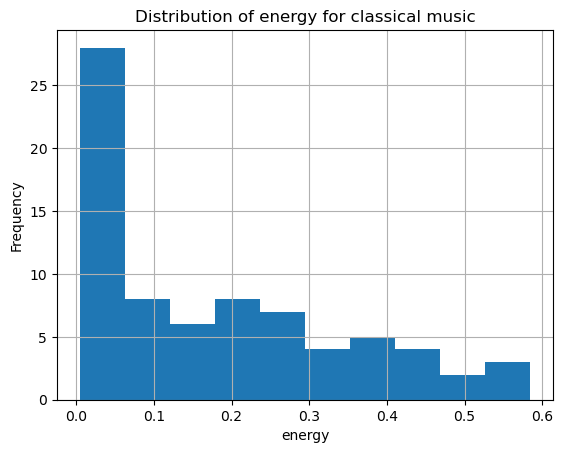

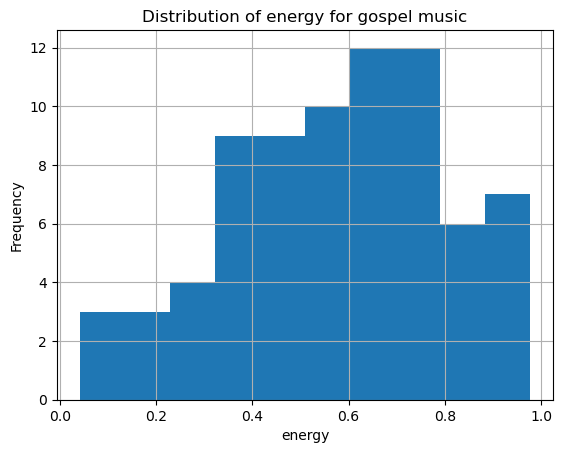

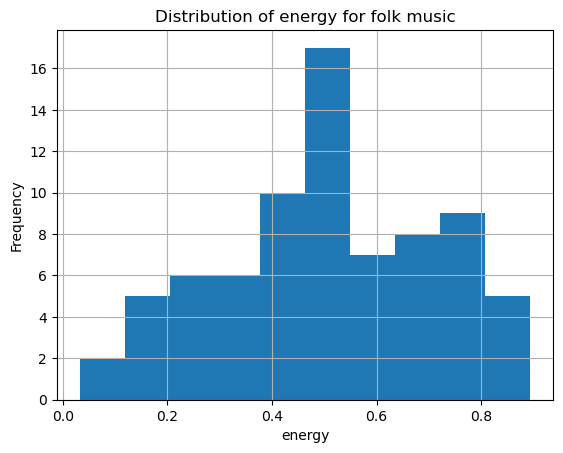

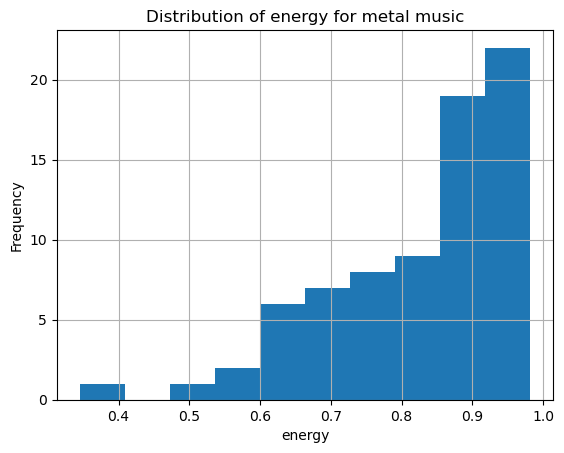

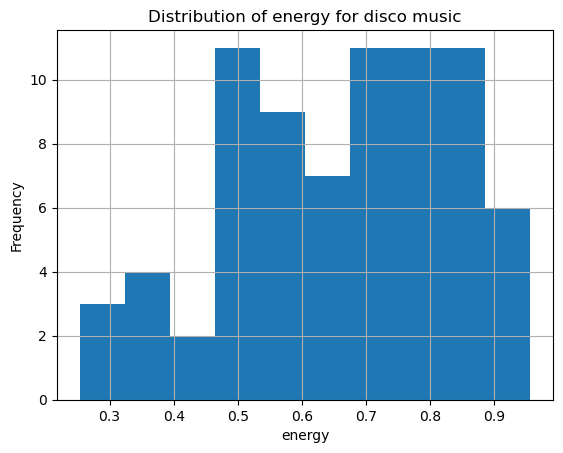

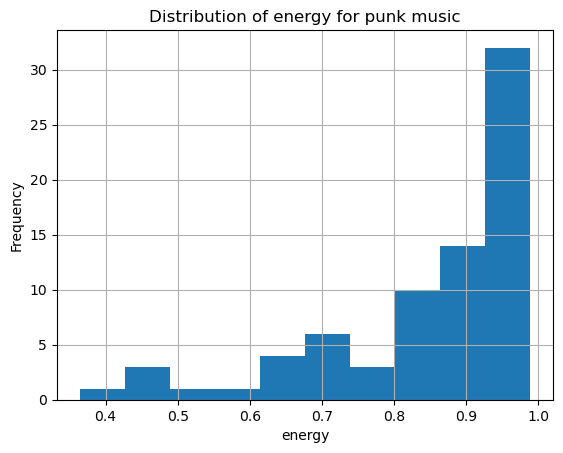

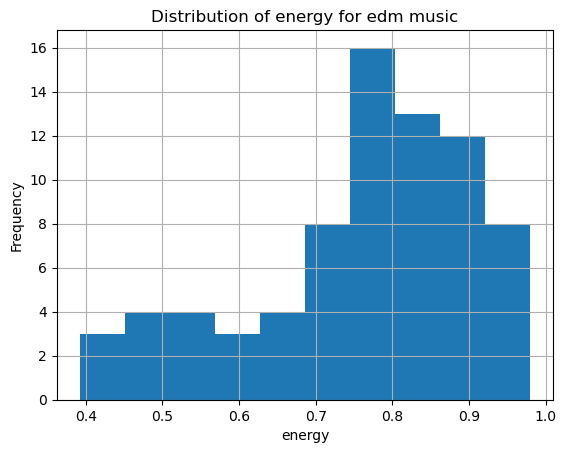

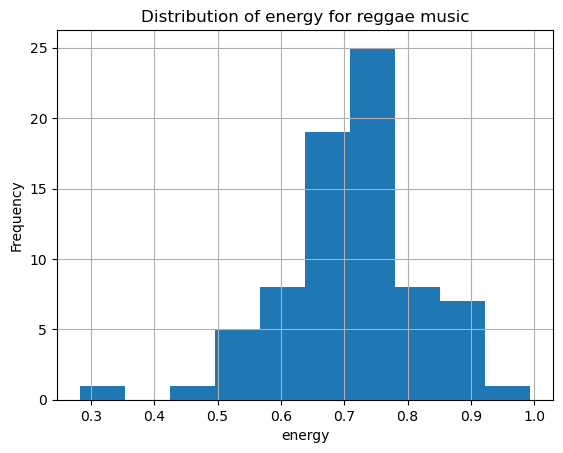

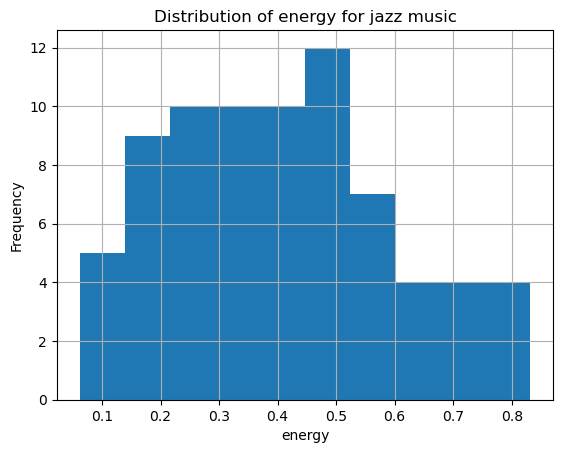

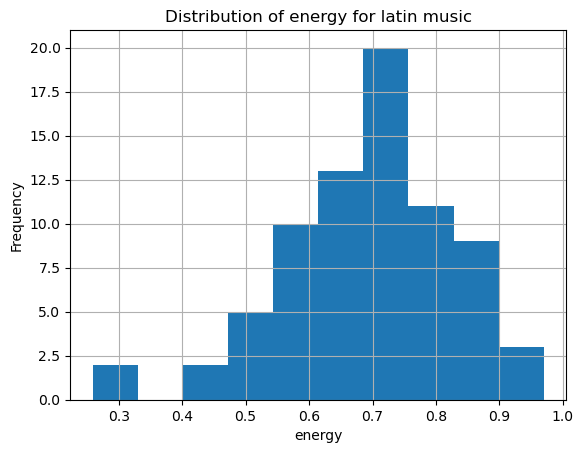

In [2676]:
for genre in top_ten_genres:
    subset = df.loc[df['genre']==genre]
    subset['energy'].hist()
    plt.xlabel('energy')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of energy for {genre} music')
    plt.show()

Distribution of metrics for the classical genre.


<Figure size 1000x600 with 0 Axes>

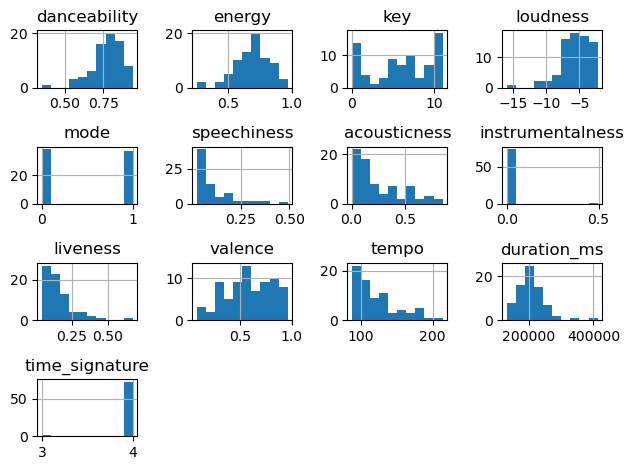

Distribution of metrics for the gospel genre.


<Figure size 1000x600 with 0 Axes>

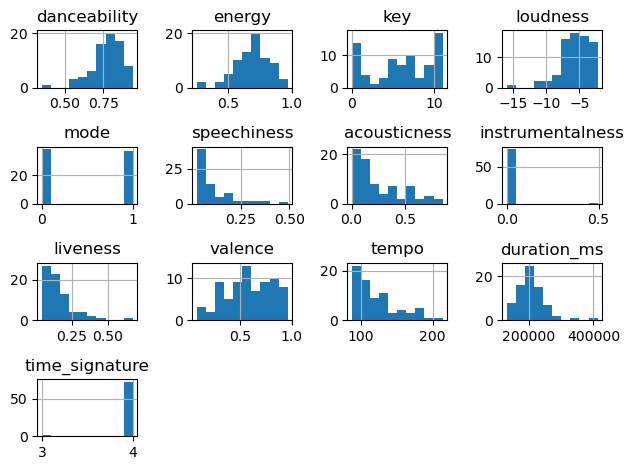

Distribution of metrics for the folk genre.


<Figure size 1000x600 with 0 Axes>

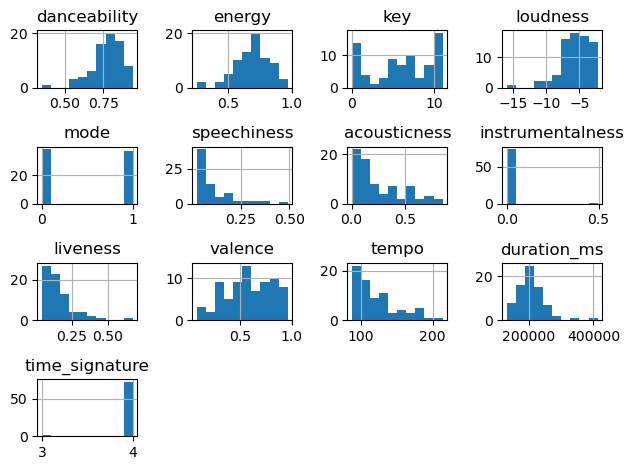

Distribution of metrics for the metal genre.


<Figure size 1000x600 with 0 Axes>

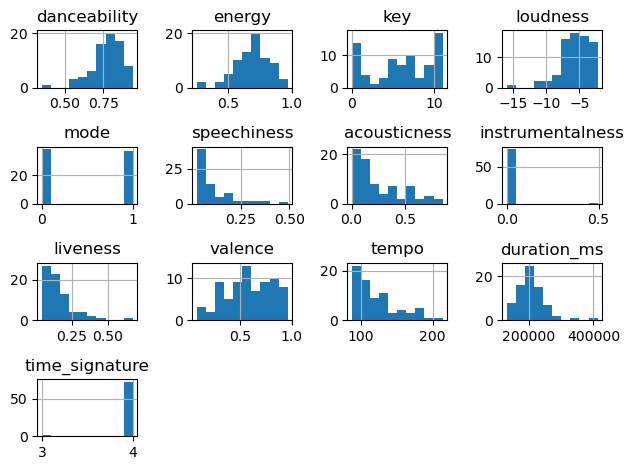

Distribution of metrics for the disco genre.


<Figure size 1000x600 with 0 Axes>

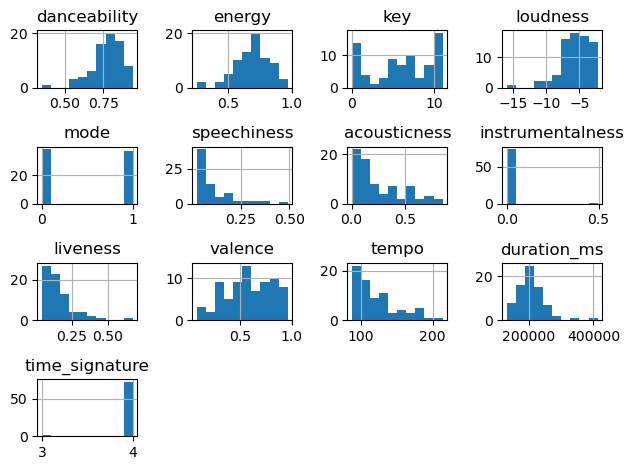

Distribution of metrics for the punk genre.


<Figure size 1000x600 with 0 Axes>

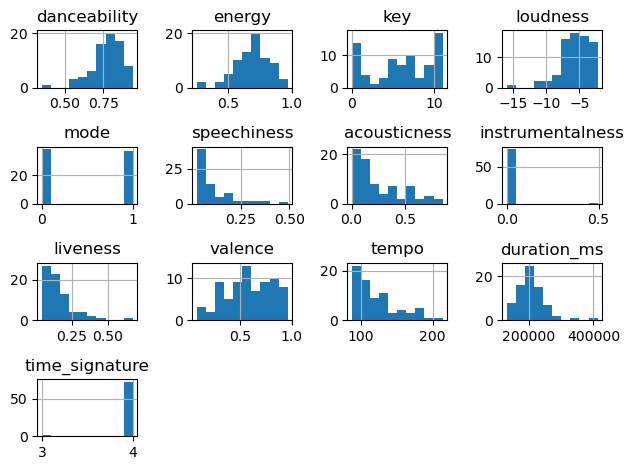

Distribution of metrics for the edm genre.


<Figure size 1000x600 with 0 Axes>

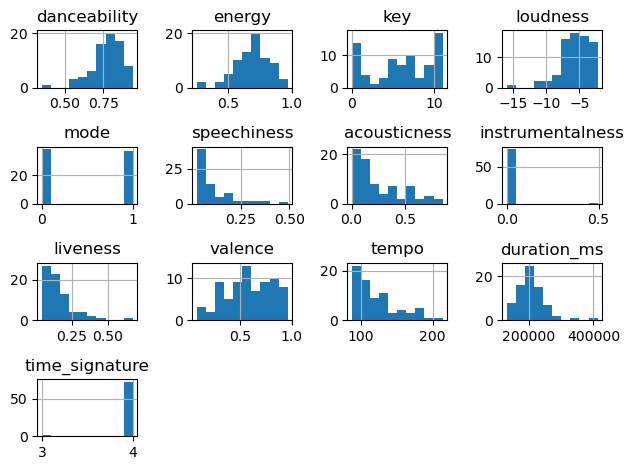

Distribution of metrics for the reggae genre.


<Figure size 1000x600 with 0 Axes>

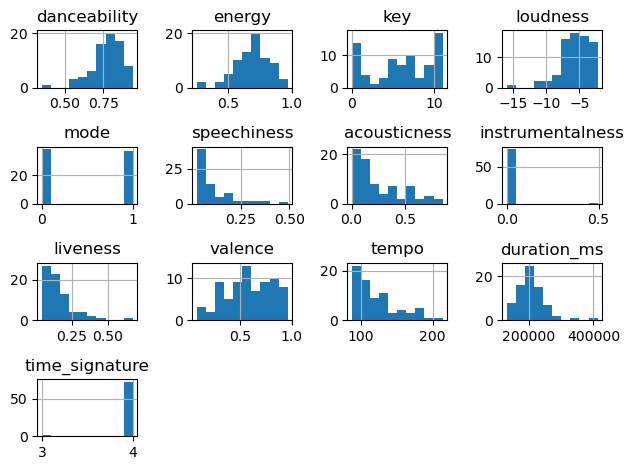

Distribution of metrics for the jazz genre.


<Figure size 1000x600 with 0 Axes>

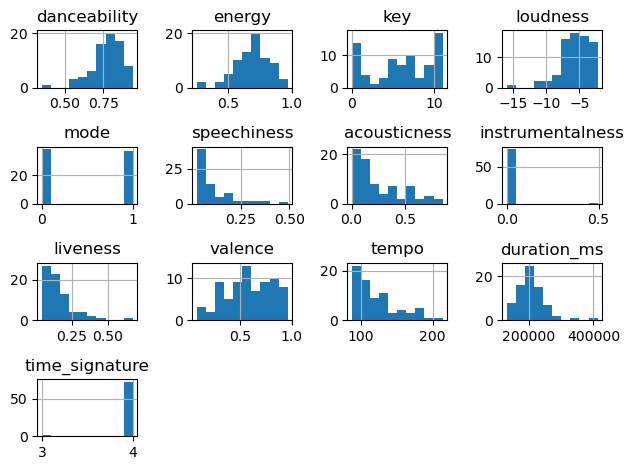

Distribution of metrics for the latin genre.


<Figure size 1000x600 with 0 Axes>

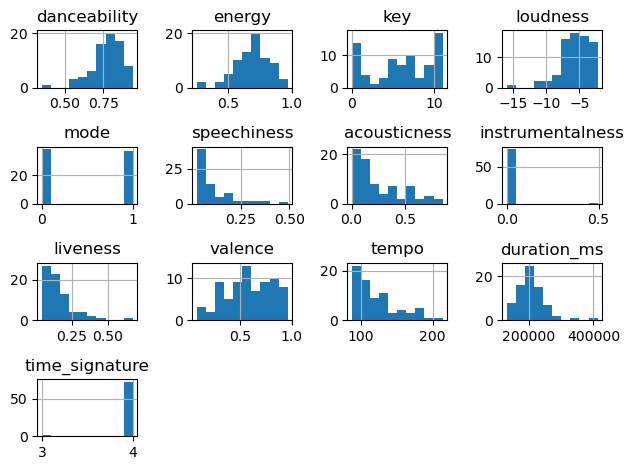

CPU times: user 9.95 s, sys: 1.33 s, total: 11.3 s
Wall time: 8.22 s


In [2678]:
%%time

df_subset = df.drop(['id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1)
for genre in top_ten_genres:
    # Filter the DataFrame for the current genre
    genre_data = df_subset[df_subset['genre'] == genre]

    print(f'Distribution of metrics for the {genre} genre.')
    plt.figure(figsize=(10, 6))  # Optional: adjust figure size
    subset.hist(bins=10)
    plt.tight_layout()
    plt.show()

There's a pretty wide distribution of numeric features between genres. Given we get our data from Spotify's API, we do not have to worry about nulls and outliers. The biggest thing that could be improved on would be the number of samples for each genre. Each successful call of the API and running of the notebook adds data to the github dataset and then reads that file to ensure that if the API is maxed out, a person can still run the code and have data for the models. 

## Data Preprocessing

In [2680]:
f1_list, auc_roc_list, accuracy_list, model_list = [], [], [], []

In [2849]:
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
def record_metrics(y_test, predictions, model, X_test):
    f1_list.append(f1_score(y_test, predictions, average='macro'))
    accuracy_list.append(accuracy_score(y_test, predictions))
    try: # Support Vector Machines are not compatible with roc_auc, hence this try block.
        auc_roc_list.append(roc_auc_score(y_test, model.predict_proba(X_test), multi_class='ovr'))
    except:
        auc_roc_list.append(np.nan)

In [2682]:
def preprocess_data(df):
    df = df.drop(['id', 'uri', 'track_href', 'analysis_url', 'type'], axis=1)
    
    df = df.dropna()
    
    # Label encode the genre column
    label_encoder = LabelEncoder()
    df['genre'] = label_encoder.fit_transform(df['genre'])
    
    
    X = df.drop(['genre'], axis=1)
    y = df['genre']
    
    # Normalize  feature values
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    return X_scaled, y, label_encoder

X, y, label_encoder = preprocess_data(df)


## Train Machine Learning Model


In [2684]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Support Vector Machine (SVM)": SVC(kernel='linear'),  # You can also try 'rbf' kernel
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

model_performance = {}

for model_name, model in models.items():
    print(f"Training {model_name}...")
    model.fit(X_train, y_train)  
    y_pred = model.predict(X_test)  
    
    # Generate classification report
    print(f"Classification Report for {model_name}:")
    report = classification_report(y_test, y_pred, target_names=label_encoder.classes_)
    print(report)
    
    model_performance[model_name] = report
    record_metrics(y_test, y_pred, model, X_test)
    model_list.append(f'{model_name}')

class_names = label_encoder.classes_

Training Random Forest...
Classification Report for Random Forest:
              precision    recall  f1-score   support

   classical       0.81      0.89      0.85        19
       disco       0.62      0.57      0.59        23
         edm       0.61      0.52      0.56        27
        folk       0.41      0.52      0.46        21
      gospel       0.50      0.40      0.44        25
        jazz       0.45      0.45      0.45        20
       latin       0.25      0.32      0.28        22
       metal       0.48      0.54      0.51        24
        punk       0.36      0.53      0.43        17
      reggae       0.23      0.11      0.15        27

    accuracy                           0.47       225
   macro avg       0.47      0.49      0.47       225
weighted avg       0.47      0.47      0.46       225

Training Support Vector Machine (SVM)...
Classification Report for Support Vector Machine (SVM):
              precision    recall  f1-score   support

   classical       0.7

### Support Vector Machine with PCA

In [2686]:
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

model_svm_pca = SVC(kernel='linear')
model_svm_pca.fit(X_train_pca, y_train)
y_pred_svm_pca = model_svm_pca.predict(X_test_pca)

print("SVM with PCA Classification Report:")
print(classification_report(y_test, y_pred_svm_pca, target_names=class_names))
record_metrics(y_test, y_pred, model, X_test)
model_list.append("SVM with PCA")

SVM with PCA Classification Report:
              precision    recall  f1-score   support

   classical       0.84      0.84      0.84        19
       disco       0.41      0.48      0.44        23
         edm       0.50      0.48      0.49        27
        folk       0.30      0.62      0.40        21
      gospel       0.46      0.24      0.32        25
        jazz       0.31      0.20      0.24        20
       latin       0.29      0.32      0.30        22
       metal       0.41      0.38      0.39        24
        punk       0.35      0.41      0.38        17
      reggae       0.18      0.11      0.14        27

    accuracy                           0.40       225
   macro avg       0.40      0.41      0.39       225
weighted avg       0.40      0.40      0.39       225



### RandomForest with class weights

In [2687]:
# Random Forest with class weights
model_rf_weighted = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
model_rf_weighted.fit(X_train, y_train)
y_pred_rf_weighted = model_rf_weighted.predict(X_test)

print("Random Forest with Class Weights Classification Report:")
print(classification_report(y_test, y_pred_rf_weighted, target_names=class_names))
record_metrics(y_test, lr_predictions, lr, X_test)
model_list.append("Random Forest with class weights")

Random Forest with Class Weights Classification Report:
              precision    recall  f1-score   support

   classical       0.81      0.89      0.85        19
       disco       0.67      0.61      0.64        23
         edm       0.62      0.56      0.59        27
        folk       0.39      0.57      0.46        21
      gospel       0.61      0.44      0.51        25
        jazz       0.43      0.45      0.44        20
       latin       0.26      0.27      0.27        22
       metal       0.54      0.58      0.56        24
        punk       0.39      0.53      0.45        17
      reggae       0.12      0.07      0.09        27

    accuracy                           0.48       225
   macro avg       0.48      0.50      0.49       225
weighted avg       0.48      0.48      0.48       225



In [2688]:
!pip install catboost

python(21691) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


### CatBoostClassifier

In [2690]:
from catboost import CatBoostClassifier

label_encoder = LabelEncoder()
df['genre'] = label_encoder.fit_transform(df['genre'])

X = df.drop(['genre'], axis=1)
y = df['genre']
categorical_features = ['id', 'uri', 'track_href', 'analysis_url', 'type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

catboost_model = CatBoostClassifier(iterations=500,
                          learning_rate=0.1,
                          depth=6,
                          eval_metric='Accuracy',
                          random_seed=42,
                          verbose=50, 
                          cat_features=categorical_features)

catboost_model.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=100)

predictions = catboost_model.predict(X_test)

print("CatBoostClassifier with Class Weights Classification Report:")
print(classification_report(y_test, predictions, target_names=class_names))
record_metrics(y_test, predictions, catboost_model, X_test)
model_list.append("CatBoostClassifier")

0:	learn: 0.4133333	test: 0.3377778	best: 0.3377778 (0)	total: 18.1ms	remaining: 9.05s
50:	learn: 0.7676190	test: 0.5022222	best: 0.5022222 (41)	total: 529ms	remaining: 4.65s
100:	learn: 0.8819048	test: 0.5333333	best: 0.5333333 (99)	total: 994ms	remaining: 3.93s
150:	learn: 0.9352381	test: 0.5555556	best: 0.5555556 (126)	total: 1.49s	remaining: 3.45s
200:	learn: 0.9714286	test: 0.5644444	best: 0.5644444 (200)	total: 2.05s	remaining: 3.06s
250:	learn: 0.9828571	test: 0.5555556	best: 0.5644444 (200)	total: 2.6s	remaining: 2.58s
300:	learn: 0.9942857	test: 0.5600000	best: 0.5688889 (264)	total: 3.11s	remaining: 2.06s
350:	learn: 0.9980952	test: 0.5644444	best: 0.5688889 (264)	total: 3.62s	remaining: 1.54s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.5688888889
bestIteration = 264

Shrink model to first 265 iterations.
CatBoostClassifier with Class Weights Classification Report:
              precision    recall  f1-score   support

   classical       0.94      0.8

### LogisticRegression

In [2692]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

X, y, label_encoder = preprocess_data(df)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr = LogisticRegression(max_iter=1000, multi_class="multinomial")
lr.fit(X_train, y_train)
lr_predictions = lr.predict(X_test)

print("LogisticRegression with Class Weights Classification Report:")
print(f1_score(y_test, lr_predictions, average='weighted'))
print(classification_report(y_test, lr_predictions, target_names=class_names))
record_metrics(y_test, lr_predictions, lr, X_test)
model_list.append("LogisticRegression")

LogisticRegression with Class Weights Classification Report:
0.4157952350158832
              precision    recall  f1-score   support

   classical       0.85      0.89      0.87        19
       disco       0.45      0.39      0.42        23
         edm       0.52      0.41      0.46        27
        folk       0.34      0.52      0.42        21
      gospel       0.50      0.28      0.36        25
        jazz       0.45      0.45      0.45        20
       latin       0.30      0.32      0.31        22
       metal       0.33      0.42      0.37        24
        punk       0.30      0.41      0.35        17
      reggae       0.27      0.22      0.24        27

    accuracy                           0.42       225
   macro avg       0.43      0.43      0.42       225
weighted avg       0.43      0.42      0.42       225



### KNeighborsClassifier

In [2694]:
from sklearn.neighbors import KNeighborsClassifier

X, y, label_encoder = preprocess_data(df)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

kn = KNeighborsClassifier(n_neighbors=5, weights='distance', 
                          algorithm='auto', leaf_size=10, p=2, 
                          metric='minkowski', metric_params=None, n_jobs=None)
kn.fit(X_train, y_train)
kn_predictions = kn.predict(X_test)

# Print classification report
print("KNeighborsClassifier with Class Weights Classification Report:")
print(f"F1 Score (Weighted): {f1_score(y_test, kn_predictions, average='weighted')}")
print(classification_report(y_test, kn_predictions, target_names=class_names))
record_metrics(y_test, kn_predictions, kn, X_test)
model_list.append("KNeighborsClassifier")


KNeighborsClassifier with Class Weights Classification Report:
F1 Score (Weighted): 0.42910549244026913
              precision    recall  f1-score   support

   classical       0.86      0.95      0.90        19
       disco       0.45      0.39      0.42        23
         edm       0.60      0.56      0.58        27
        folk       0.43      0.62      0.51        21
      gospel       0.47      0.28      0.35        25
        jazz       0.35      0.30      0.32        20
       latin       0.23      0.27      0.25        22
       metal       0.42      0.33      0.37        24
        punk       0.34      0.59      0.43        17
      reggae       0.26      0.22      0.24        27

    accuracy                           0.44       225
   macro avg       0.44      0.45      0.44       225
weighted avg       0.44      0.44      0.43       225



### Prediction Function

In [2839]:
def predict_genre(track: str, artist: str, X_train, y_train, model, sp, top_ten_genres):
    # Search for the track and artist
    results = sp.search(q=f'track:{track} artist:{artist}', type='track', limit=1)
    for item in results['tracks']['items']:
        track_id = item['id']
        audio_features = get_audio_features(track_id)

        # I check if the genre is in the top ten genres and that the track is not in the training data. We don't want to test the model
        # on data it trained on.
        if (audio_features['genre'] in top_ten_genres and 
                track_id not in X_train['id'].values and 
                track_id not in y_train.values):
            
            # I eliminate unnecessary columns 
            features = audio_features.drop(columns=['id', 'uri', 'track_href', 'analysis_url', 'type', 'genre'], axis=1)

            # I make the prediction
            predicted_genre = model.predict(features)
            return predicted_genre, audio_features['genre'].values[0]  # Return the predicted genre and actual genre
        else:
            return ('Track is either in a training set, an unused genre, or not findable by Spotify API')

In [2841]:
predict_genre(track='breath away', artist='Artemis', X_train=X_train, y_train=y_train, model=catboost_model, sp=sp, top_ten_genres=top_ten_genres)

In [2843]:
predict_genre(track='Sleepwalking', artist='Chiiild', X_train=X_train, y_train=y_train, model=catboost_model, sp=sp, top_ten_genres=top_ten_genres)

Max Retries reached


SpotifyException: http status: 429, code:-1 - /v1/audio-features/?ids=050TMrxpzlXGYRDAjnrSp6:
 Max Retries, reason: too many 429 error responses

# Conclusions

In [2698]:
model_list

['Random Forest',
 'Support Vector Machine (SVM)',
 'Gradient Boosting',
 'SVM with PCA',
 'Random Forest with class weights',
 'CatBoostClassifier',
 'LogisticRegression',
 'KNeighborsClassifier']

In [2699]:
results_df = pd.DataFrame(columns=['model', 'f1', 'AUC_ROC', 'Accuracy'])

results_df['model'] = model_list
results_df['f1'] = f1_list
results_df['AUC_ROC'] = auc_roc_list
results_df['Accuracy'] = accuracy_list

results_df.head(10)

,model,f1,AUC_ROC,Accuracy
0,Random Forest,0.472206,0.885439,0.471111
1,Support Vector Machine (SVM),0.424195,NaN,0.426667
2,Gradient Boosting,0.464789,0.867793,0.457778
3,SVM with PCA,0.464789,0.867793,0.457778
4,Random Forest with class weights,0.429641,NaN,0.422222
5,CatBoostClassifier,0.574362,0.913466,0.568889
6,LogisticRegression,0.424918,0.874830,0.417778
7,KNeighborsClassifier,0.437653,0.773724,0.435556


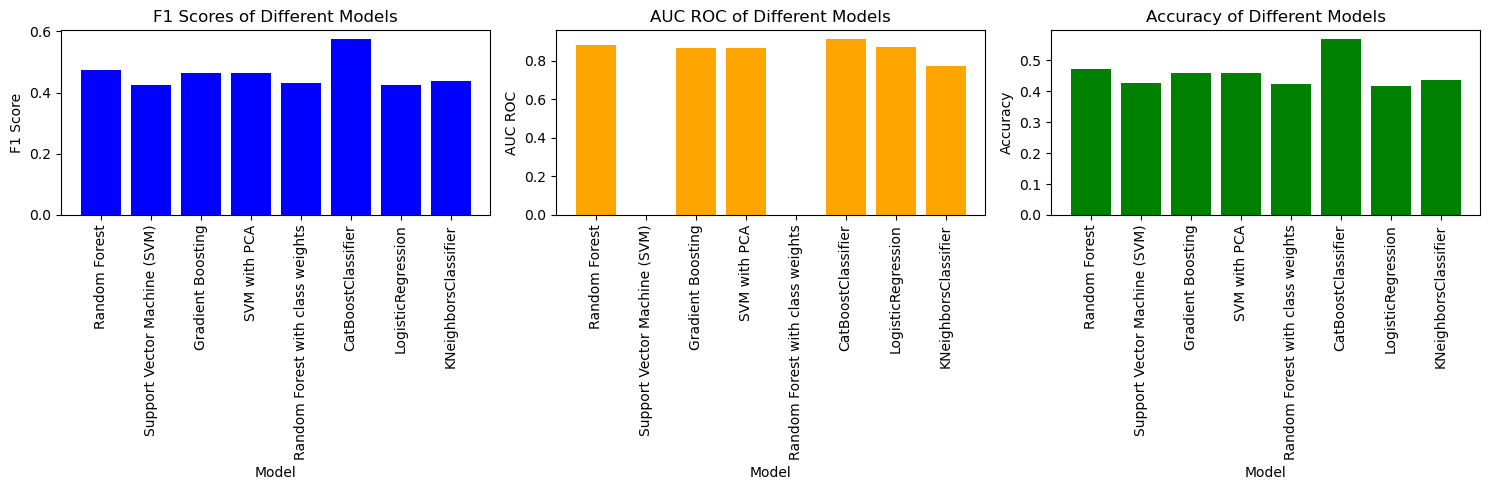

In [2720]:
plt.figure(figsize=(15, 5))

# Bar graph for F1 Score
plt.subplot(1, 3, 1)
plt.bar(results_df['model'], results_df['f1'], color='blue')
plt.xlabel('Model')
plt.ylabel('F1 Score')
plt.title('F1 Scores of Different Models')
plt.xticks(rotation=90)

# Bar graph for AUC ROC
plt.subplot(1, 3, 2)
plt.bar(results_df['model'], results_df['AUC_ROC'], color='orange')
plt.xlabel('Model')
plt.ylabel('AUC ROC')
plt.title('AUC ROC of Different Models')
plt.xticks(rotation=90)

# Bar graph for Accuracy
plt.subplot(1, 3, 3)
plt.bar(results_df['model'], results_df['Accuracy'], color='green')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xticks(rotation=90)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

- The CatBoostClassifier works best for the AUC_ROC, accuracy, and f1 metrics. Metrics for all the models tried were collected in the above table for easy comparison. A constant model would be right only 10% of the time. CatBoost had an overall accuracy of .57. Classification reports were generated for each model for ease of comparison across individual genres and models. Support Vector Machines are incompatible with roc_auc scores so a np.nan was left in that spot in the table and graphs.
- The easiest way to improve models' performances would be to add more data to the 'clean_spotify_set2.csv' file. The code has been set up to allow for automatic updating of the dataset to increase the variety of data it has to work with, while checking for duplicates.
- This code originally classified between 20 genres. The genres were shrunk to raise overall accuracy metrics for the models and allow the models to make clearer distinctions. The top ten most accurate genres from that list of 20 were chosen. Classical music consistently was the most identifiable across models. Of the original 20, the genre 'Soul' was least likely to be recognized which seems strangely appropriate of a computer. The API call still requests 20 different genres even though only ten were used for model training to try to keep the dataset as balanced as possible.
- The predict_genre() method was not able to be tested given certain restrictions with the API and relatively tight timeframe for this project.